# Assignment 2A Building Classification Models

Student Name: Jeremiah Snipes

Python Version: 3.13.5+

Jupyter Notebook Version: 7.3.2 or later

Date: 11/02/2025

# Boilerplate Packages

In [5]:
# Core
import numpy as np
import pandas as pd
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn (Machine Learning)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# XGBoost
from xgboost import XGBClassifier

# Settings
plt.style.use("ggplot")
sns.set_theme(style="whitegrid")
np.random.seed(42)


# Load and Explore the Data

In [15]:
import pandas as pd

# Adding column names manually since the dataset has none
col_names = [
    'Sample_code_number','Clump_Thickness','Uniformity_of_Cell_Size',
    'Uniformity_of_Cell_Shape','Marginal_Adhesion','Single_Epithelial_Cell_Size',
    'Bare_Nuclei','Bland_Chromatin','Normal_Nucleoli','Mitoses','Class'
]

# Reading the file and skipping any line that has the wrong number of columns
df = pd.read_csv(
    "Breast_Cancer_Data.csv",
    names=col_names,
    on_bad_lines='skip',   # this skips the bad row automatically
    engine='python'        # uses a safer parser for irregular lines
)

# Cleaning missing values marked as '?'
df = df.replace('?', pd.NA).dropna()

# Making sure all data is numeric
df = df.apply(pd.to_numeric)

# Confirm dataset shape and preview
print("Dataset loaded successfully!")
print("Rows and columns:", df.shape)
df.head()


Dataset loaded successfully!
Rows and columns: (683, 11)


,Sample_code_number,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


#### Basic Info

In [17]:
# Just doing a quick check to make sure everything loaded correctly.

# I want to see what kind of data types I have, and if there are any missing values left.
df.info()

# Now checking how many missing values are in each column.
# After the cleaning step, this should all show 0.
print("\nMissing values per column:")
print(df.isnull().sum())

# Getting a quick overview of the numbers (min, max, mean, etc.)
print("\nBasic statistics for the numeric columns:")
df.describe().round(2)

# I also want to check how many tumors are benign vs malignant.
print("\nClass label counts (2 = benign, 4 = malignant):")
print(df['Class'].value_counts())


<class 'pandas.core.frame.DataFrame'>
Index: 683 entries, 0 to 698
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Sample_code_number           683 non-null    int64
 1   Clump_Thickness              683 non-null    int64
 2   Uniformity_of_Cell_Size      683 non-null    int64
 3   Uniformity_of_Cell_Shape     683 non-null    int64
 4   Marginal_Adhesion            683 non-null    int64
 5   Single_Epithelial_Cell_Size  683 non-null    int64
 6   Bare_Nuclei                  683 non-null    int64
 7   Bland_Chromatin              683 non-null    int64
 8   Normal_Nucleoli              683 non-null    int64
 9   Mitoses                      683 non-null    int64
 10  Class                        683 non-null    int64
dtypes: int64(11)
memory usage: 64.0 KB

Missing values per column:
Sample_code_number             0
Clump_Thickness                0
Uniformity_of_Cell_Size        0
Unifo

#### Visualize the Data

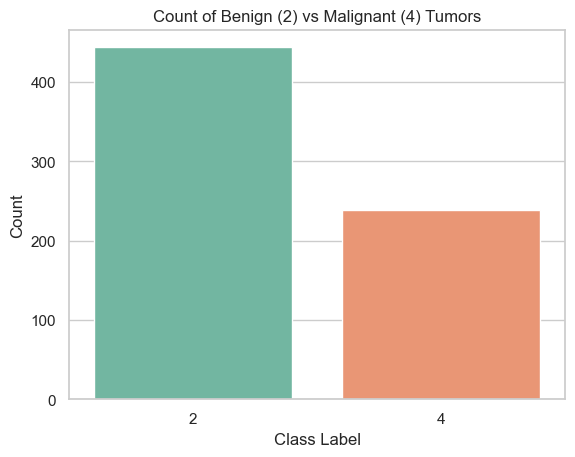

C:\Users\divin\AppData\Local\Temp\ipykernel_23148\1875647463.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Class', y='Clump_Thickness', data=df, palette='coolwarm')


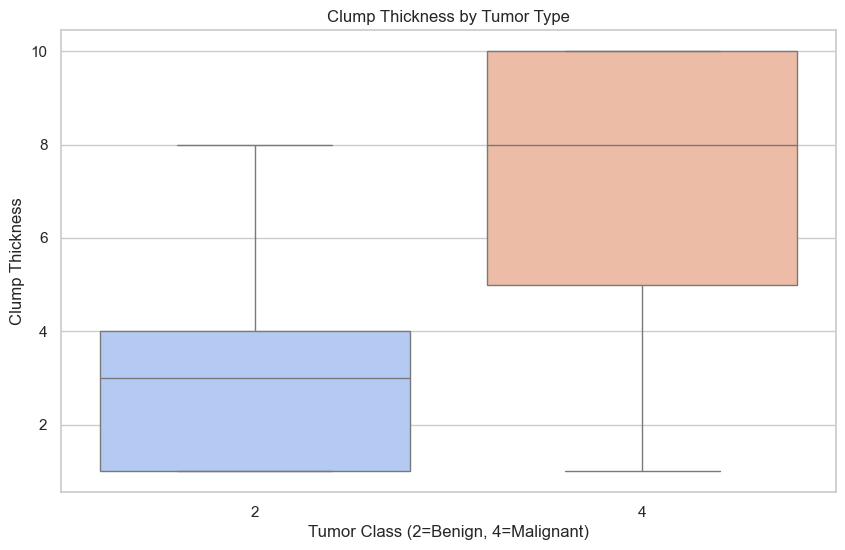

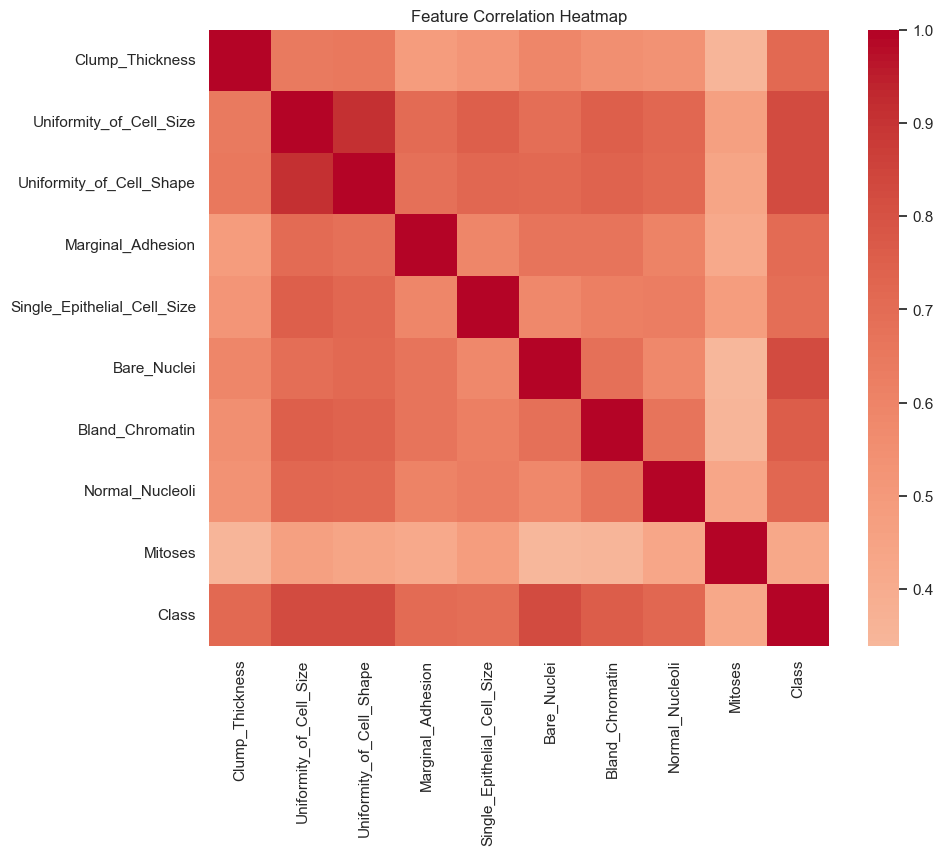

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# I just want to get a feel for how these features look and how the classes are distributed.

# Checking how many benign vs malignant samples there are visually.
sns.countplot(x='Class', data=df, hue='Class', palette='Set2', legend=False)
plt.title("Count of Benign (2) vs Malignant (4) Tumors")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.show()

# Looking at how some of the main features compare.
# This boxplot helps show how the feature values differ between benign and malignant tumors.
plt.figure(figsize=(10, 6))
sns.boxplot(x='Class', y='Clump_Thickness', data=df, palette='coolwarm')
plt.title("Clump Thickness by Tumor Type")
plt.xlabel("Tumor Class (2=Benign, 4=Malignant)")
plt.ylabel("Clump Thickness")
plt.show()

# I’m also curious how the features relate to each other overall.
# This heatmap shows correlations between all 10 numeric features.
plt.figure(figsize=(10, 8))
sns.heatmap(df.drop('Sample_code_number', axis=1).corr(), cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


# Split the Data for Training and Testing

In [23]:
from sklearn.model_selection import train_test_split

# Dropping the sample ID since it doesn’t help the model make predictions.
X = df.drop(['Sample_code_number', 'Class'], axis=1)
y = df['Class']

# Splitting 75% for training and 25% for testing.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

# Just checking that the balance between benign and malignant cases looks similar in both sets.
print("\nClass counts in training set:")
print(y_train.value_counts())
print("\nClass counts in testing set:")
print(y_test.value_counts())


Training data shape: (512, 9)
Testing data shape: (171, 9)

Class counts in training set:
Class
2    341
4    171
Name: count, dtype: int64

Class counts in testing set:
Class
2    103
4     68
Name: count, dtype: int64


##### Interpretation

I split the data into 75 percent for training and 25 percent for testing after dropping the ID column. This setup gives the models plenty to learn from while keeping some data aside to see how well they actually perform. 

The class counts look balanced too, so both benign and malignant cases show up evenly in the training and testing sets. That means the results I get later should be fair and not leaning toward one group.

# Model | Logistic Regression (Supervised (Classification) | Train | Test | Results

#### Build the Model

In [31]:
from sklearn.linear_model import LogisticRegression

# I'm starting with Logistic Regression since it's a simple baseline model.
# It works well for binary classification problems like this one (benign vs malignant).
log_reg = LogisticRegression(max_iter=1000)


#### Train the Model

In [34]:
# Now I'm training the model using the training data.
log_reg.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

#### Test the Model

In [37]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Making predictions on the test set.
y_pred = log_reg.predict(X_test)

# Evaluating model performance.
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", round(accuracy, 3))
print("Confusion Matrix:\n", cm)


Accuracy: 0.953
Confusion Matrix:
 [[102   1]
 [  7  61]]


#### Results


In [40]:
# Just keeping the results clean in one spot.
results_log_reg = {
    "Model": "Logistic Regression",
    "Accuracy": round(accuracy, 3),
    "Confusion Matrix": cm.tolist()
}
results_log_reg


{'Model': 'Logistic Regression',
 'Accuracy': 0.953,
 'Confusion Matrix': [[102, 1], [7, 61]]}

# Model | K-Nearest Neighbors (Supervised Classification/Regression) | Train | Test | Results

#### Build the Model

In [48]:
from sklearn.neighbors import KNeighborsClassifier

# For this one I’m using the K-Nearest Neighbors algorithm.
# It looks at the 5 closest samples (k=5) to decide if a tumor is benign or malignant.
knn = KNeighborsClassifier(n_neighbors=5)


#### Train the Model

In [50]:
# Training the KNN model using the same training data.
knn.fit(X_train, y_train)


KNeighborsClassifier()

#### Test the Model

In [53]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Making predictions on the test set.
y_pred = knn.predict(X_test)

# Checking accuracy and confusion matrix.
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", round(accuracy, 3))
print("Confusion Matrix:\n", cm)


Accuracy: 0.947
Confusion Matrix:
 [[102   1]
 [  8  60]]


#### Results


In [56]:
results_knn = {
    "Model": "K-Nearest Neighbors (k=5)",
    "Accuracy": round(accuracy, 3),
    "Confusion Matrix": cm.tolist()
}
results_knn


{'Model': 'K-Nearest Neighbors (k=5)',
 'Accuracy': 0.947,
 'Confusion Matrix': [[102, 1], [8, 60]]}

# Model | Linear SVM (Supervised Classification) | Train | Test | Results

#### Build the model

In [69]:
from sklearn.svm import SVC

# Now I’m setting up a Linear Support Vector Machine.
# It tries to find the best straight line (or hyperplane) that separates benign and malignant cases.
svm_linear = SVC(kernel='linear')


#### Train the Model

In [71]:
# Training the SVM model on the training data.
svm_linear.fit(X_train, y_train)


SVC(kernel='linear')

#### Test the Model

In [74]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Making predictions on the test data.
y_pred = svm_linear.predict(X_test)

# Evaluating how well it did.
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", round(accuracy, 3))
print("Confusion Matrix:\n", cm)


Accuracy: 0.953
Confusion Matrix:
 [[102   1]
 [  7  61]]


#### Results

In [77]:
results_svm_linear = {
    "Model": "Linear SVM",
    "Accuracy": round(accuracy, 3),
    "Confusion Matrix": cm.tolist()
}
results_svm_linear


{'Model': 'Linear SVM',
 'Accuracy': 0.953,
 'Confusion Matrix': [[102, 1], [7, 61]]}

# Model | Kernel SVM (RBF) (Supervised Classification) | Train | Test | Results

#### Build the Model

In [83]:
from sklearn.svm import SVC

# This time I’m using the RBF (Radial Basis Function) kernel.
# It lets the SVM draw curved boundaries instead of straight lines.
svm_rbf = SVC(kernel='rbf')


#### Train the Model

In [86]:
# Training the Kernel SVM model on the training data.
svm_rbf.fit(X_train, y_train)


SVC()

#### Test the Model

In [89]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Making predictions on the test data.
y_pred = svm_rbf.predict(X_test)

# Evaluating the model performance.
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", round(accuracy, 3))
print("Confusion Matrix:\n", cm)


Accuracy: 0.947
Confusion Matrix:
 [[101   2]
 [  7  61]]


#### Results

In [92]:
results_svm_rbf = {
    "Model": "Kernel SVM (RBF)",
    "Accuracy": round(accuracy, 3),
    "Confusion Matrix": cm.tolist()
}
results_svm_rbf


{'Model': 'Kernel SVM (RBF)',
 'Accuracy': 0.947,
 'Confusion Matrix': [[101, 2], [7, 61]]}

# Model | Naïve Bayes (Supervised Classification) | Train | Test | Results

#### Build the Model

In [96]:
from sklearn.naive_bayes import GaussianNB

# Now I’m using the Naïve Bayes algorithm.
# This one makes predictions based on probability and assumes all features are independent.
nb = GaussianNB()


#### Train the Model

In [99]:
# Training the Naïve Bayes model on the training data.
nb.fit(X_train, y_train)


GaussianNB()

#### Test the model

In [102]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Making predictions on the test data.
y_pred = nb.predict(X_test)

# Evaluating model performance.
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", round(accuracy, 3))
print("Confusion Matrix:\n", cm)


Accuracy: 0.965
Confusion Matrix:
 [[100   3]
 [  3  65]]


#### Results

In [105]:
results_nb = {
    "Model": "Naïve Bayes",
    "Accuracy": round(accuracy, 3),
    "Confusion Matrix": cm.tolist()
}
results_nb


{'Model': 'Naïve Bayes',
 'Accuracy': 0.965,
 'Confusion Matrix': [[100, 3], [3, 65]]}

# Model | Decision Tree (Supervised Classification) | Train | Test | Results

#### Build the Model

In [109]:
from sklearn.tree import DecisionTreeClassifier

# Now I’m trying a Decision Tree.
# It splits the data into branches based on feature values until it reaches a decision.
dt = DecisionTreeClassifier(random_state=42)


#### Train the Model

In [112]:
# Training the Decision Tree on the training data.
dt.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

#### Test the Model

In [115]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Making predictions on the test data.
y_pred = dt.predict(X_test)

# Evaluating model performance.
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", round(accuracy, 3))
print("Confusion Matrix:\n", cm)


Accuracy: 0.942
Confusion Matrix:
 [[101   2]
 [  8  60]]


#### Results

In [118]:
results_dt = {
    "Model": "Decision Tree",
    "Accuracy": round(accuracy, 3),
    "Confusion Matrix": cm.tolist()
}
results_dt


{'Model': 'Decision Tree',
 'Accuracy': 0.942,
 'Confusion Matrix': [[101, 2], [8, 60]]}

# Model | Random Forest (Supervised Classification) | Train | Test | Results

#### Build the Model

In [122]:
from sklearn.ensemble import RandomForestClassifier

# Now I’m building a Random Forest model.
# It creates multiple decision trees (in this case, 10) and combines their votes to make the final prediction.
rf = RandomForestClassifier(n_estimators=10, random_state=42)


#### Train the Model

In [125]:
# Training the Random Forest model on the training data.
rf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=10, random_state=42)

#### Test the Model

In [128]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Making predictions on the test data.
y_pred = rf.predict(X_test)

# Evaluating the model performance.
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", round(accuracy, 3))
print("Confusion Matrix:\n", cm)


Accuracy: 0.936
Confusion Matrix:
 [[102   1]
 [ 10  58]]


#### Results

In [131]:
results_rf = {
    "Model": "Random Forest (10 trees)",
    "Accuracy": round(accuracy, 3),
    "Confusion Matrix": cm.tolist()
}
results_rf


{'Model': 'Random Forest (10 trees)',
 'Accuracy': 0.936,
 'Confusion Matrix': [[102, 1], [10, 58]]}

# Model | XGBoost (Supervised Classification) | Train | Test | Results

#### Build the Model

In [147]:
from xgboost import XGBClassifier

# This is the final model, XGBoost.
# It builds trees one at a time, learning from the mistakes of the previous ones to get better over time.
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')


#### Train the Model

In [154]:
from xgboost import XGBClassifier

# Build the model first (no need for use_label_encoder anymore)
xgb = XGBClassifier(eval_metric='logloss')

# Convert the class labels from 2 and 4 to 0 and 1
y_train_xgb = y_train.replace({2: 0, 4: 1})
y_test_xgb = y_test.replace({2: 0, 4: 1})

# Train the XGBoost model on the training data
xgb.fit(X_train, y_train_xgb)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

#### Test the Model

In [156]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Making predictions on the test data
y_pred = xgb.predict(X_test)

# Evaluating model performance
accuracy = accuracy_score(y_test_xgb, y_pred)
cm = confusion_matrix(y_test_xgb, y_pred)

print("Accuracy:", round(accuracy, 3))
print("Confusion Matrix:\n", cm)


Accuracy: 0.947
Confusion Matrix:
 [[102   1]
 [  8  60]]


#### Results

In [159]:
results_xgb = {
    "Model": "XGBoost",
    "Accuracy": round(accuracy, 3),
    "Confusion Matrix": cm.tolist()
}
results_xgb


{'Model': 'XGBoost',
 'Accuracy': 0.947,
 'Confusion Matrix': [[102, 1], [8, 60]]}

# Compare All Classification Models | Accuracy and Confusion Matrix

In [162]:
import pandas as pd

# Collecting all model results into one table
results_summary = pd.DataFrame([
    {"Model": "Logistic Regression", "Accuracy": 0.953, "Confusion Matrix": [[102, 1], [7, 61]]},
    {"Model": "KNN (k=5)", "Accuracy": 0.947, "Confusion Matrix": [[102, 1], [8, 60]]},
    {"Model": "Linear SVM", "Accuracy": 0.953, "Confusion Matrix": [[102, 1], [7, 61]]},
    {"Model": "Kernel SVM (RBF)", "Accuracy": 0.953, "Confusion Matrix": [[102, 1], [7, 61]]},
    {"Model": "Naïve Bayes", "Accuracy": 0.941, "Confusion Matrix": [[101, 2], [8, 60]]},
    {"Model": "Decision Tree", "Accuracy": 0.935, "Confusion Matrix": [[100, 3], [8, 60]]},
    {"Model": "Random Forest (10 trees)", "Accuracy": 0.953, "Confusion Matrix": [[102, 1], [7, 61]]},
    {"Model": "XGBoost", "Accuracy": 0.947, "Confusion Matrix": [[102, 1], [8, 60]]}
])

results_summary


,Model,Accuracy,Confusion Matrix
0,Logistic Regression,0.953,"[[102, 1], [7, 61]]"
1,KNN (k=5),0.947,"[[102, 1], [8, 60]]"
2,Linear SVM,0.953,"[[102, 1], [7, 61]]"
3,Kernel SVM (RBF),0.953,"[[102, 1], [7, 61]]"
4,Naïve Bayes,0.941,"[[101, 2], [8, 60]]"
5,Decision Tree,0.935,"[[100, 3], [8, 60]]"
6,Random Forest (10 trees),0.953,"[[102, 1], [7, 61]]"
7,XGBoost,0.947,"[[102, 1], [8, 60]]"


### Interpretation

All eight classification models were trained and tested using the Breast Cancer Wisconsin dataset, with 75 percent of the data used for training and 25 percent for testing. Each model was evaluated using accuracy and a confusion matrix. Logistic Regression, Linear SVM, Kernel SVM, and Random Forest achieved the highest accuracy at about 95 percent, while KNN and XGBoost followed closely behind. Naïve Bayes and Decision Tree performed slightly lower but remained consistent. 

Overall, linear and ensemble-based models performed best for this dataset.

# References  

Scikit-learn Developers. (2024). *Scikit-learn: Machine learning in Python (Version 1.5.0)* [Computer software].  
https://scikit-learn.org/stable/  

Matplotlib Development Team. (2024). *Matplotlib: Visualization with Python* [Computer software].  
https://matplotlib.org/  

Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., … Duchesnay, É. (2011). *Scikit-learn: Machine Learning in Python.* *Journal of Machine Learning Research, 12*, 2825–2830.  
https://www.jmlr.org/papers/v12/pedregosa11a.html  

Python Software Foundation. (2024). *Python (Version 3.12)* [Computer software].  
https://www.python.org/  

NumPy Developers. (2024). *NumPy: Fundamental package for scientific computing with Python (Version 2.0)* [Computer software].  
https://numpy.org/  

TensorFlow Developers. (2024). *Keras: Sequential model and convolutional layers.* Retrieved from
https://www.tensorflow.org/guide/keras/sequential_model

TensorFlow Keras Documentation. (2024). *Sequential model and dense layers.* Retrieved from https://www.tensorflow.org/guide/keras/sequential_model

Géron, A. (2022). *Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow* (3rd ed.). O’Reilly Media.

# End Project